In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the main data and convert index to datetime
data = pd.read_csv("data/Hawthorne/Site_3006_raw.csv", index_col=0)
data.index = pd.to_datetime(data.index, errors='coerce')

# Load the UV data and convert index to datetime
UVdata = pd.read_csv("data/UV Data/UV Data All Time HW LP RB.csv", index_col=0)
UVdata = UVdata[['HW']]
UVdata.index = pd.to_datetime(UVdata.index, errors='coerce')

# Merge the dataframes by their date indices
data = data.merge(UVdata, left_index=True, right_index=True)

data.rename(columns={'HW': 'UV'}, inplace=True)
data['UV'].apply(lambda x: x if x > 0 else np.nan)

# Drop any rows with NaN values and filter for positive SR_Synoptic
data.dropna(inplace=True)
data.head()



/var/folders/8y/j4zbl6y95zn4hrbsnlzpz6yc0000gn/T/ipykernel_10146/3571888263.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  UVdata.index = pd.to_datetime(UVdata.index, errors='coerce')


,NO,NO2,O3,SR,Temp,SR_Synoptic,UV
datetime,,,,,,,
2023-04-28 09:00:00,2.200000,6.15,0.052,0.98,59.0,137.0,19.0
2023-04-28 12:00:00,2.566667,7.85,0.059,1.32,66.0,686.0,18.0
2023-04-28 13:00:00,1.433333,5.55,0.066,1.28,66.0,813.0,12.0
2023-04-28 14:00:00,0.933333,4.60,0.070,1.17,68.0,893.0,23.0
2023-04-28 15:00:00,0.800000,4.45,0.071,0.99,69.0,920.0,18.0


## Calculating K
- Convert Temp to K
- Calculate K

In [83]:
# Coversion
data['Temp[K]'] = (data['Temp'] - 32) * 5/9 + 273.15

# K calc
A = 3.0e-12
EoR = 1500
data['K'] = A * np.exp(-EoR / (data['Temp[K]'])) #This unit seems to be cm**3 Molecules**-1 s**-1

## Calculating J

In [ ]:
C=7.784e-5
data['J']=C*data['UV'] 


# Change concentration units
- Ozone ppm -> ppb -> ppbv
- NO ppb -> ppbv
- NOx ppb -> ppbv

In [ ]:
number = 2.46E10
data['O3'] = data['O3'] * 1000 * number 
data['NO'] = data['NO'] * number 
data['NO2'] = data['NO2'] * number

datetime
2023-04-28 09:00:00    0.196391
2023-04-28 12:00:00    0.167392
2023-04-28 13:00:00    0.126298
2023-04-28 14:00:00    0.284912
2023-04-28 15:00:00    0.245720
                         ...   
2025-10-08 17:00:00    0.104740
2025-10-09 07:00:00    0.091072
2025-10-09 08:00:00    0.108086
2025-10-09 09:00:00    0.131032
2025-10-09 10:00:00    0.166695
Name: LR, Length: 10020, dtype: float64


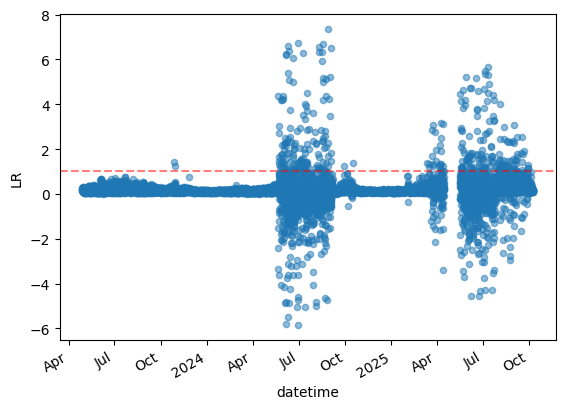

In [89]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data['LR'] = (data['J']*data['NO2'])/(data['K']*data['O3']*data['NO'])
data['LR'] = data['LR'].apply(lambda x: x if x >= -40 else np.nan)
data['LR'] = data['LR'].apply(lambda x: x if x <= 40 else np.nan)
data['LR'] = data['LR'].apply(lambda x: np.nan if x == 0 else x)
data.dropna(inplace=True)
print(data['LR'])
data.to_csv('data/Hawthorne/Leighton_Relationship_HW.csv')

fig, ax = plt.subplots()
data.reset_index().plot(kind='scatter', x='datetime', y='LR', alpha=0.5, ax=ax)
ax.axhline(y=1, color='r', linestyle='--', alpha=0.5)
# data['LR'].plot(kind='hist', bins=100)





ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

fig.autofmt_xdate()
